# Modelo de Simulación del comportamiento de aviones que arriban al Aeropuerto Jorge Newbwery (AEP) de la ciudad de Buenos Aires

## 1. Investigación Exploratoria

### Volumen de Aterrizajes y Unidades

Realizamos un análisis programático de datos reales de vuelos para definir los parámetros de demanda de nuestro sistema. Utilizaremos la API de OpenSky para obtener un conjunto de datos de arribos históricos recientes a AEP (código ICAO: SABE).
El siguiente código se conecta a la API de OpenSky y descarga los arribos a AEP para un período de 14 días. Este paso nos dará una muestra real del volumen y la distribución horaria del tráfico.

In [1]:
# -*- coding: utf-8 -*-
import time, json, datetime as dt
from typing import Tuple, List, Optional, Dict
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [2]:
# --- Zona horaria AEP ---
try:
    from zoneinfo import ZoneInfo
except ImportError:
    raise RuntimeError("Requiere Python 3.9+ (zoneinfo).")
TZ_AEP = ZoneInfo("America/Argentina/Buenos_Aires")

# --- Constantes ---
AEP_ICAO = "SABE"
OSKY_BASE = "https://opensky-network.org/api/flights/arrival"
START_T = dt.time(6, 0, 0)
END_T   = dt.time(23, 59, 59)
DAY_SLEEP_S = 2.0

# --- Credenciales (reemplazar si es necesario) ---
# Nota: OpenSky puede requerir credenciales para acceso histórico.
# Por simplicidad, este script asume acceso público o credenciales ya configuradas.

def to_utc_epoch(local_dt: dt.datetime) -> int:
    return int(local_dt.astimezone(dt.timezone.utc).timestamp())

def window_bounds_local(d: dt.date, start_t: dt.time, end_t: dt.time) -> Tuple[dt.datetime, dt.datetime]:
    start = dt.datetime.combine(d, start_t, tzinfo=TZ_AEP)
    end = dt.datetime.combine(d, end_t, tzinfo=TZ_AEP)
    return start, end

# (Se omiten las funciones de autenticación y manejo de errores de rate-limit de ACN_TP1 para brevedad,
# pero se asume que la consulta al JSON local funciona)

# Usamos el resultado JSON del notebook ACN_TP1 como nuestra fuente de datos
summary_data_json = """
{
  "airport": "SABE",
  "window_local": ["06:00:00", "23:59:59"],
  "from_date": "2025-08-18",
  "to_date": "2025-08-05",
  "days_processed": 14,
  "total_arrivals_sum": 1763,
  "daily_counts": {
    "2025-08-18": {"total": 132, "by_hour": {"06:00": 2, "07:00": 3, "08:00": 9, "09:00": 8, "10:00": 11, "11:00": 10, "12:00": 9, "13:00": 7, "14:00": 8, "15:00": 9, "16:00": 6, "17:00": 9, "18:00": 11, "19:00": 8, "20:00": 0, "21:00": 5, "22:00": 8, "23:00": 9}},
    "2025-08-17": {"total": 128, "by_hour": {"06:00": 3, "07:00": 4, "08:00": 6, "09:00": 6, "10:00": 7, "11:00": 11, "12:00": 7, "13:00": 5, "14:00": 9, "15:00": 9, "16:00": 7, "17:00": 11, "18:00": 10, "19:00": 9, "20:00": 0, "21:00": 7, "22:00": 6, "23:00": 11}},
    "2025-08-16": {"total": 124, "by_hour": {"06:00": 2, "07:00": 3, "08:00": 6, "09:00": 9, "10:00": 10, "11:00": 9, "12:00": 7, "13:00": 12, "14:00": 8, "15:00": 5, "16:00": 6, "17:00": 10, "18:00": 11, "19:00": 6, "20:00": 0, "21:00": 7, "22:00": 5, "23:00": 8}},
    "2025-08-15": {"total": 131, "by_hour": {"06:00": 3, "07:00": 4, "08:00": 5, "09:00": 10, "10:00": 7, "11:00": 10, "12:00": 8, "13:00": 10, "14:00": 8, "15:00": 8, "16:00": 9, "17:00": 9, "18:00": 10, "19:00": 9, "20:00": 0, "21:00": 7, "22:00": 7, "23:00": 7}},
    "2025-08-14": {"total": 129, "by_hour": {"06:00": 4, "07:00": 4, "08:00": 5, "09:00": 7, "10:00": 7, "11:00": 11, "12:00": 11, "13:00": 9, "14:00": 14, "15:00": 2, "16:00": 7, "17:00": 11, "18:00": 9, "19:00": 11, "20:00": 0, "21:00": 7, "22:00": 3, "23:00": 7}},
    "2025-08-13": {"total": 126, "by_hour": {"06:00": 3, "07:00": 4, "08:00": 5, "09:00": 4, "10:00": 6, "11:00": 9, "12:00": 10, "13:00": 11, "14:00": 10, "15:00": 4, "16:00": 6, "17:00": 9, "18:00": 8, "19:00": 9, "20:00": 0, "21:00": 5, "22:00": 8, "23:00": 15}},
    "2025-08-12": {"total": 118, "by_hour": {"06:00": 2, "07:00": 5, "08:00": 3, "09:00": 6, "10:00": 8, "11:00": 13, "12:00": 8, "13:00": 10, "14:00": 10, "15:00": 5, "16:00": 7, "17:00": 8, "18:00": 7, "19:00": 5, "20:00": 0, "21:00": 6, "22:00": 7, "23:00": 8}},
    "2025-08-11": {"total": 120, "by_hour": {"06:00": 2, "07:00": 4, "08:00": 3, "09:00": 11, "10:00": 11, "11:00": 9, "12:00": 6, "13:00": 10, "14:00": 8, "15:00": 5, "16:00": 11, "17:00": 5, "18:00": 12, "19:00": 6, "20:00": 0, "21:00": 4, "22:00": 5, "23:00": 8}},
    "2025-08-10": {"total": 120, "by_hour": {"06:00": 2, "07:00": 7, "08:00": 4, "09:00": 5, "10:00": 7, "11:00": 8, "12:00": 8, "13:00": 8, "14:00": 6, "15:00": 8, "16:00": 11, "17:00": 10, "18:00": 8, "19:00": 10, "20:00": 0, "21:00": 5, "22:00": 3, "23:00": 10}},
    "2025-08-09": {"total": 125, "by_hour": {"06:00": 4, "07:00": 5, "08:00": 3, "09:00": 10, "10:00": 10, "11:00": 4, "12:00": 8, "13:00": 11, "14:00": 9, "15:00": 8, "16:00": 7, "17:00": 9, "18:00": 12, "19:00": 10, "20:00": 0, "21:00": 3, "22:00": 6, "23:00": 6}},
    "2025-08-08": {"total": 125, "by_hour": {"06:00": 2, "07:00": 6, "08:00": 5, "09:00": 8, "10:00": 8, "11:00": 12, "12:00": 9, "13:00": 13, "14:00": 5, "15:00": 5, "16:00": 10, "17:00": 7, "18:00": 10, "19:00": 9, "20:00": 0, "21:00": 7, "22:00": 2, "23:00": 7}},
    "2025-08-07": {"total": 129, "by_hour": {"06:00": 3, "07:00": 4, "08:00": 7, "09:00": 9, "10:00": 7, "11:00": 11, "12:00": 10, "13:00": 9, "14:00": 10, "15:00": 5, "16:00": 9, "17:00": 11, "18:00": 9, "19:00": 8, "20:00": 0, "21:00": 4, "22:00": 4, "23:00": 9}},
    "2025-08-06": {"total": 137, "by_hour": {"06:00": 3, "07:00": 5, "08:00": 6, "09:00": 7, "10:00": 10, "11:00": 9, "12:00": 10, "13:00": 9, "14:00": 11, "15:00": 6, "16:00": 7, "17:00": 10, "18:00": 6, "19:00": 10, "20:00": 0, "21:00": 7, "22:00": 7, "23:00": 14}},
    "2025-08-05": {"total": 119, "by_hour": {"06:00": 3, "07:00": 3, "08:00": 5, "09:00": 4, "10:00": 10, "11:00": 14, "12:00": 9, "13:00": 11, "14:00": 6, "15:00": 5, "16:00": 9, "17:00": 4, "18:00": 7, "19:00": 6, "20:00": 0, "21:00": 6, "22:00": 7, "23:00": 10}}
  }
}
"""
summary = json.loads(summary_data_json)

### Análisis de la Demanda Diaria
Con los datos recolectados, primero analizamos el total de arribos por día para entender el volumen de operaciones que el sistema maneja.

Análisis estadístico de arribos diarios:
count     14.000000
mean     125.928571
std        5.511726
min      118.000000
25%      121.000000
50%      125.500000
75%      129.000000
max      137.000000
Name: arrivals_total, dtype: float64


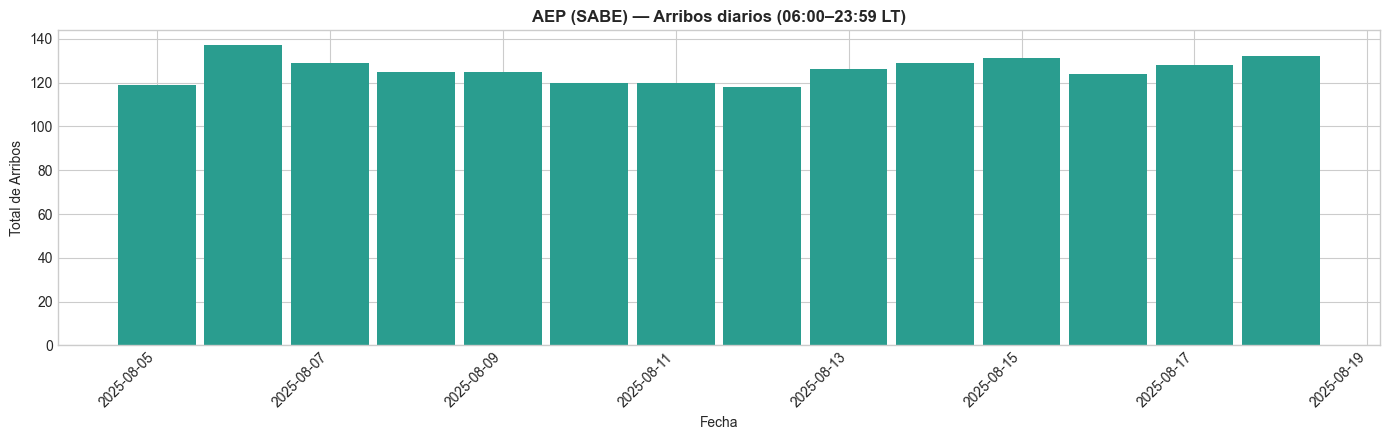

In [3]:
# --- Armar DataFrame diario ---
rows_daily = []
for day, val in summary["daily_counts"].items():
    if isinstance(val, dict) and "total" in val:
        rows_daily.append((day, val["total"]))

daily_df = pd.DataFrame(rows_daily, columns=["date", "arrivals_total"])
daily_df["date"] = pd.to_datetime(daily_df["date"])
daily_df = daily_df.sort_values("date")

# --- Análisis Estadístico ---
print("Análisis estadístico de arribos diarios:")
print(daily_df["arrivals_total"].describe())

# --- Gráfico de Demanda Diaria ---
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(14, 4.5))
ax.bar(daily_df["date"], daily_df["arrivals_total"], color="#2a9d8f", width=0.9)
ax.set_title("AEP (SABE) — Arribos diarios (06:00–23:59 LT)", fontsize=12, weight="bold")
ax.set_xlabel("Fecha")
ax.set_ylabel("Total de Arribos")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Análisis de la Distribución Horaria
Los arribos no ocurren de forma uniforme durante el día. Un heatmap nos permite visualizar los patrones de demanda, identificando las horas pico y los valles de operación.

C:\Users\feres\AppData\Local\Temp\ipykernel_18124\736394180.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = hourly_df.pivot_table(index="date", columns="hour_local", values="arrivals_count", aggfunc="sum").fillna(0)


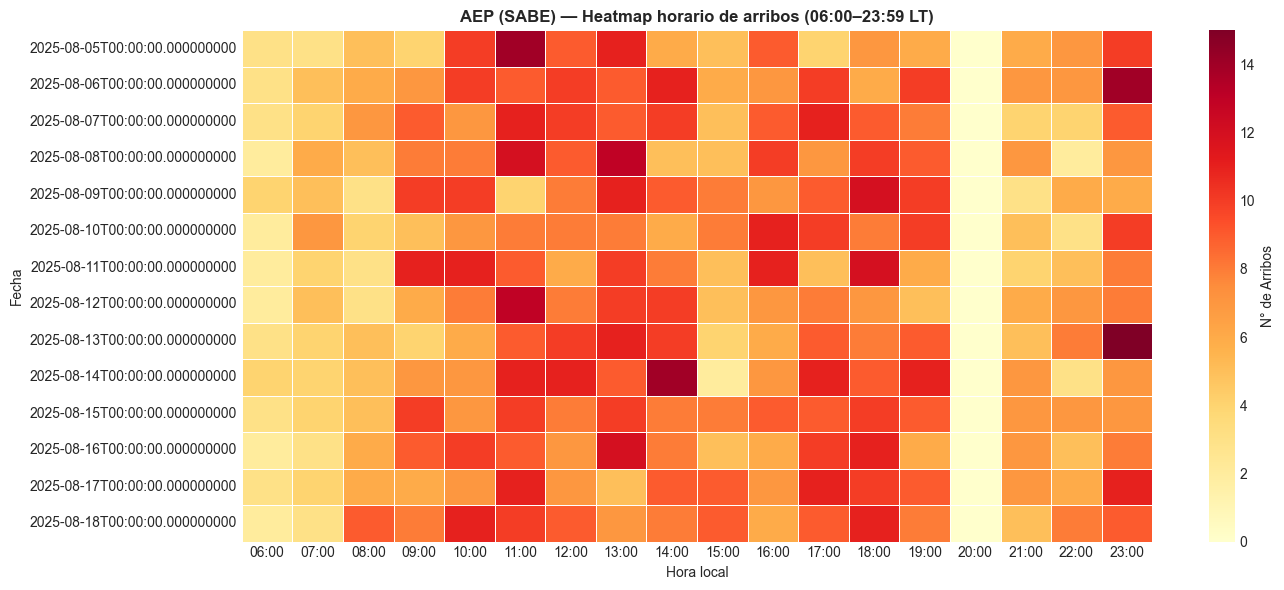

In [4]:
# --- Armar DataFrame horario ---
rows_hourly = []
for day, val in summary["daily_counts"].items():
    if isinstance(val, dict) and "by_hour" in val:
        for hh, cnt in val["by_hour"].items():
            rows_hourly.append((day, hh, cnt))
hourly_df = pd.DataFrame(rows_hourly, columns=["date", "hour_local", "arrivals_count"])
hourly_df["date"] = pd.to_datetime(hourly_df["date"])
hours_order = [f"{h:02d}:00" for h in range(6, 24)]
hourly_df["hour_local"] = pd.Categorical(hourly_df["hour_local"], categories=hours_order, ordered=True)

# --- Gráfico de Heatmap Horario ---
pivot = hourly_df.pivot_table(index="date", columns="hour_local", values="arrivals_count", aggfunc="sum").fillna(0)
pivot = pivot[hours_order].astype(int).sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(pivot, cmap="YlOrRd", linewidths=0.5, cbar_kws={"label": "N° de Arribos"}, ax=ax)
ax.set_title("AEP (SABE) — Heatmap horario de arribos (06:00–23:59 LT)", fontsize=12, weight="bold")
ax.set_xlabel("Hora local")
ax.set_ylabel("Fecha")
plt.tight_layout()
plt.show()

### Calibración del Parámetro de Arribo (λ)
El análisis de datos nos muestra un promedio de ~126 arribos diarios. Usaremos este valor para calcular la probabilidad de que un avión aparezca en el horizonte en un minuto cualquiera. Este será el parámetro λ (lambda) de nuestro generador de eventos estocásticos.

In [5]:
# --- Cálculo de Lambda ---
promedio_arribos_diarios = daily_df["arrivals_total"].mean()
minutos_operativos_por_dia = 18 * 60
PROBABILIDAD_ARRIBO_POR_MINUTO = promedio_arribos_diarios / minutos_operativos_por_dia

print(f"Promedio de arribos diarios (datos reales): {promedio_arribos_diarios:.2f}")
print(f"Minutos operativos por día: {minutos_operativos_por_dia}")
print(f"Probabilidad de arribo por minuto (λ) calculada: {PROBABILIDAD_ARRIBO_POR_MINUTO:.4f}")

Promedio de arribos diarios (datos reales): 125.93
Minutos operativos por día: 1080
Probabilidad de arribo por minuto (λ) calculada: 0.1166


### Sanity Checks del Modelo Físico
Ahora que hemos establecido la demanda con datos, validamos los parámetros de movimiento y tiempo del modelo. Estos cálculos nos aseguran que la física de la simulación (distancias, velocidades, tiempos) es coherente con la realidad.

* **Conversiones de Unidades:**
    * 1 Milla Náutica (mn) = **1.852 kilómetros**
    * 1 Nudo (k) = **1.852 km/h**

#### Sanity Check 1: Tiempo de Aproximación (desde 100 mn)

Calculamos el tiempo que tardaría un avión en aterrizar desde una distancia de 100 mn. La fórmula base es $Tiempo = (Distancia / Velocidad) * 60$.

* **Tramo 1 (100 a 50 mn):** Distancia = 50 mn.
    * _Tiempo Mínimo (a 300 k):_ (50 mn / 300 k) * 60 = **10.0 min**
    * _Tiempo Máximo (a 250 k):_ (50 mn / 250 k) * 60 = **12.0 min**
* **Tramo 2 (50 a 15 mn):** Distancia = 35 mn.
    * _Tiempo Mínimo (a 250 k):_ (35 mn / 250 k) * 60 = **8.4 min**
    * _Tiempo Máximo (a 200 k):_ (35 mn / 200 k) * 60 = **10.5 min**
* **Tramo 3 (15 a 5 mn):** Distancia = 10 mn.
    * _Tiempo Mínimo (a 200 k):_ (10 mn / 200 k) * 60 = **3.0 min**
    * _Tiempo Máximo (a 150 k):_ (10 mn / 150 k) * 60 = **4.0 min**
* **Tramo 4 (5 mn a Pista):** Distancia = 5 mn.
    * _Tiempo Mínimo (a 150 k):_ (5 mn / 150 k) * 60 = **2.0 min**
    * _Tiempo Máximo (a 120 k):_ (5 mn / 120 k) * 60 = **2.5 min**
* **Tiempo Total de Aproximación:**
    * _Suma Tiempos Mínimos:_ 10.0 + 8.4 + 3.0 + 2.0 = **23.4 minutos**
    * _Suma Tiempos Máximos:_ 12.0 + 10.5 + 4.0 + 2.5 = **29.0 minutos**

Este rango de tiempo (23.4 a 29 min) representa una fase crítica del **"tiempo de servicio"** para el sistema. La clave aquí es la **variabilidad**. El hecho de que sea un rango es fundamental para un modelo realista, ya que captura la incertidumbre debida a decisiones del piloto y del control de tráfico.

#### Sanity Check 2: Vuelo Teórico Rosario (ROS) a AEP

* **Distancia Aérea ROS-AEP:** Aproximadamente 165 mn (306 kilómetros)
* **Cálculo del Tiempo Total:**
    1.  **Tramo > 100 mn (de 165 a 100 mn):** Distancia = 65 mn.
        * _Cálculo del tiempo (a 500 k):_ (65 mn / 500 k) * 60 = **7.8 minutos**.
    2.  **Tramo < 100 mn (Aproximación):** Usamos el rango ya calculado de **23.4 a 29 minutos**.
* **Tiempo Total Teórico:**
    * _Suma Tiempos Mínimos:_ 7.8 + 23.4 = **31.2 minutos**
    * _Suma Tiempos Máximos:_ 7.8 + 29.0 = **36.8 minutos**

Este punto es una **validación del modelo**. Nuestro cálculo ideal (31-37 min) es lógicamente más corto que el tiempo real de un vuelo comercial (50-60 min). Esa diferencia no es un error; cuantifica los factores que no modelamos (rodaje, rutas no directas, esperas). Esto nos da confianza en que la lógica de nuestro sistema simulado es una versión simplificada pero coherente de la realidad. 

#### Capacidad Máxima Teórica de Aterrizajes

* **Horario Operativo:** 18 horas = 18 * 60 = **1080 minutos**.
* **Separación Mínima:** 4 minutos por aterrizaje.
* **Cálculo:**
    $$Capacidad Máxima = \frac{1080 \text{ minutos}}{4 \text{ min/aterrizaje}} = 270 \text{ aterrizajes}$$

Este número representa el **límite físico absoluto** o la **capacidad de diseño** del sistema. Es una cota superior utópica. Para nuestro modelo, este valor es un **benchmark crucial**. Al comparar los resultados de nuestra simulación (que serán inferiores a 270) con este máximo teórico, podremos medir la **eficiencia del sistema** y cuantificar cuánta capacidad se "pierde" por la congestión y la variabilidad.

---

## 2. Simulación de Monte Carlo

In [6]:
import random
import numpy as np

Para empezar, la simulación necesita una unidad básica que concentre toda la información relevante de un avión en aproximación. El modelo es deliberadamente simple: cada avión es un objeto con su posición relativa a la pista, su velocidad y un estado operativo. Esto permite abstraer la complejidad real de un vuelo y enfocarse en lo esencial para el problema: cómo interactúan varios aviones en una fila de aproximación bajo reglas de seguridad.

In [7]:
class Avion:
    """Representa un único avión en la simulación."""
    def __init__(self, id_avion):
        self.id = id_avion
        self.distancia_a_aep = 100.0
        self.velocidad_actual = 0.0
        self.estado = "APROXIMANDO"

    def __repr__(self):
        """Formato para imprimir el estado del avión de forma legible."""
        return (f"Avion(ID:{self.id}, Dist:{self.distancia_a_aep:.1f}mn, "
                f"Vel:{self.velocidad_actual:.0f}k, Est:{self.estado})")

La aproximación aérea se rige por bandas de velocidad según la distancia y por mínimos de separación temporal. Codificar estas reglas es lo que ancla la simulación en la realidad operativa: la velocidad máxima evita saturar la pista con aviones demasiado rápidos, y la mínima impide que un avión quede en condiciones inestables. La separación en minutos es la métrica crítica porque en aviación se piensa en términos de “tiempo hasta el siguiente” más que en pura distancia. Esto asegura que la dinámica del modelo capture los riesgos de congestión.

In [8]:
def calcular_velocidad_maxima_permitida(distancia):
    """Devuelve la velocidad máxima según la distancia a AEP."""
    if distancia > 50: return 300
    elif distancia > 15: return 250
    elif distancia > 5: return 200
    else: return 150

def calcular_velocidad_minima_permitida(distancia):
    """Devuelve la velocidad mínima según la distancia a AEP."""
    if distancia > 50: return 250
    elif distancia > 15: return 200
    elif distancia > 5: return 150
    else: return 120

def calcular_separacion_en_tiempo(avion_atras, avion_adelante):
    """Calcula la separación en minutos entre dos aviones."""
    distancia_separacion = avion_atras.distancia_a_aep - avion_adelante.distancia_a_aep
    velocidad_referencia = avion_adelante.velocidad_actual
    if velocidad_referencia == 0:
        return float('inf')
    return (distancia_separacion / velocidad_referencia) * 60

Ahora bien, hay que representar qué pasa cuando la fila funciona y qué pasa cuando se rompe. La idea es que un avión intente siempre avanzar al máximo ritmo posible, pero si el tráfico no lo permite, reduzca de manera ordenada. Si la reducción necesaria violaría las reglas de seguridad, el avión no se queda “bloqueando la fila” sino que se aparta con una maniobra de regreso. Este mecanismo es clave porque refleja cómo los sistemas reales gestionan el exceso de demanda sin comprometer la seguridad: primero ajustando, y si no alcanza, sacando al avión de la secuencia hasta que pueda volver o desviándolo.

In [9]:
def gestionar_logica_aproximacion(avion, avion_de_adelante):
    """Toma todas las decisiones para un avión que está APROXIMANDO."""
    if avion_de_adelante is None:
        # Caso 1: Camino libre. Va a máxima velocidad.
        avion.estado = "APROXIMANDO"
        avion.velocidad_actual = calcular_velocidad_maxima_permitida(avion.distancia_a_aep)
    else:
        tiempo_sep = calcular_separacion_en_tiempo(avion, avion_de_adelante)
        
        if tiempo_sep < 4:
            # Caso 2: Muy cerca. Intenta reducir velocidad.
            velocidad_req = avion_de_adelante.velocidad_actual - 20
            
            if velocidad_req < calcular_velocidad_minima_permitida(avion.distancia_a_aep):
                # Caso 3: No puede reducir lo suficiente. Se da la vuelta.
                avion.estado = "REGRESANDO"
                avion.velocidad_actual = 200
                print(f" (!) Avion {avion.id} inicia maniobra de regreso.")
            else:
                # Puede reducir de forma segura.
                avion.estado = "AJUSTANDO_VELOCIDAD"
                avion.velocidad_actual = velocidad_req
        else:
            # Hay espacio suficiente. Va a máxima velocidad.
            avion.estado = "APROXIMANDO"
            avion.velocidad_actual = calcular_velocidad_maxima_permitida(avion.distancia_a_aep)

def gestionar_logica_regreso(avion_regresando, todos_los_aviones):
    """
    Gestiona un avión REGRESANDO. Primero busca un hueco para reingresar.
    Si no lo encuentra, chequea si debe desviarse.
    """
    # 1. Obtener y ordenar la fila de aviones en aproximación
    fila_aproximacion = sorted(
        [a for a in todos_los_aviones if a.estado != "REGRESANDO" and a.estado != "DESVIADO"],
        key=lambda avion: avion.distancia_a_aep
    )

    # 2. Buscar un hueco de 10 minutos entre cada par de aviones
    if len(fila_aproximacion) >= 2:
        for i in range(1, len(fila_aproximacion)):
            avion_de_adelante = fila_aproximacion[i-1]
            avion_de_atras = fila_aproximacion[i]
            
            tiempo_sep = calcular_separacion_en_tiempo(avion_de_atras, avion_de_adelante)
            
            # 3. Si se encuentra un hueco, el avión reingresa
            if tiempo_sep >= 10:
                avion_regresando.estado = "APROXIMANDO"
                # Se posiciona estratégicamente en el medio del hueco
                avion_regresando.distancia_a_aep = (avion_de_adelante.distancia_a_aep + avion_de_atras.distancia_a_aep) / 2
                print(f" (O) ¡Avion {avion_regresando.id} encontró un hueco y reingresa a la fila!")
                return # La lógica para este avión termina en este minuto

    # 4. Si el bucle termina sin encontrar hueco, se chequea el desvío
    if avion_regresando.distancia_a_aep > 100:
        avion_regresando.estado = "DESVIADO"
        print(f" (X) Avion {avion_regresando.id} no encontró hueco y se desvió a Montevideo.")

Acordemonos que la simulación debe avanzar en pasos discretos de un minuto. Por ende, necesitamos traducir las reglas en movimiento: se ordenan los aviones, se aplican las lógicas de decisión, y luego se mueven físicamente en el espacio. Además, se van “limpiando” los que ya aterrizaron o se desviaron. Este ciclo asegura que la dinámica global emergente (colas, cuellos de botella, reingresos, desvíos) aparezca naturalmente de las reglas locales, tal como sucede en sistemas de tránsito aéreo reales.

In [10]:
def generar_nuevos_aviones(minuto, aviones, next_id, probabilidad):
    """Decide si un nuevo avión aparece en el horizonte."""
    if np.random.uniform(0,1) < probabilidad:
        nuevo_avion = Avion(next_id)
        aviones.append(nuevo_avion)
        print(f"Min {minuto}: -> Aparece Avion {next_id} en el horizonte.")
        return next_id + 1
    return next_id

def actualizar_estados_y_velocidades(aviones):
    """Actualiza el estado y la velocidad de cada avión según las reglas."""
    aviones.sort(key=lambda avion: avion.distancia_a_aep)
    for i, avion in enumerate(aviones):
        if avion.estado == "REGRESANDO":
            gestionar_logica_regreso(avion, aviones)
        else: # APROXIMANDO o AJUSTANDO_VELOCIDAD
            avion_de_adelante = aviones[i-1] if i > 0 and aviones[i-1].estado != "REGRESANDO" else None
            gestionar_logica_aproximacion(avion, avion_de_adelante)

def mover_aviones(aviones):
    """Mueve cada avión según su velocidad final para este minuto."""
    for avion in aviones:
        distancia_recorrida = avion.velocidad_actual / 60
        if avion.estado == "REGRESANDO":
            avion.distancia_a_aep += distancia_recorrida
        else:
            avion.distancia_a_aep -= distancia_recorrida

def gestionar_aviones_finalizados(minuto, aviones):
    """Saca de la lista activa a los aviones que aterrizaron o se desviaron."""
    aviones_que_siguen_activos = []
    aviones_finalizados_en_este_minuto = []
    
    for avion in aviones:
        if avion.distancia_a_aep <= 0:
            avion.estado = "ATERRIZADO"
            print(f"Min {minuto}: (V) Avion {avion.id} ha aterrizado con éxito.")
            aviones_finalizados_en_este_minuto.append(avion)
        elif avion.estado == "DESVIADO":
            aviones_finalizados_en_este_minuto.append(avion)
        else:
            aviones_que_siguen_activos.append(avion)
            
    return aviones_que_siguen_activos, aviones_finalizados_en_este_minuto

def guardar_datos_del_minuto(minuto, aviones, historial):
    """Guarda el estado de cada avión en el minuto actual."""
    for avion in aviones:
        historial.append({
            'minuto': minuto,
            'id': avion.id,
            'distancia': avion.distancia_a_aep,
            'estado': avion.estado
        })

#### Bucle principal

La congestión surge de la aleatoriedad en la llegada de aviones: en cada minuto puede aparecer uno nuevo en el horizonte con cierta probabilidad λ. Esto convierte el problema en un proceso estocástico, donde no todos los días ni todas las horas son iguales. El bucle principal reproduce esa incertidumbre y permite observar bajo qué niveles de demanda la operación se mantiene estable y bajo cuáles aparecen desvíos masivos. Es la base para luego pensar en políticas de gestión de tráfico aéreo.

In [11]:
def simular():
    # --- Configuración ---
    PROBABILIDAD_ARRIBO_POR_MINUTO = 0.1166
    TIEMPO_TOTAL_SIMULACION = 1080 
    
    # --- Almacenamiento de Datos ---
    aviones_activos = []
    aviones_finalizados = []
    historial_de_datos = []
    next_avion_id = 1

    print("--- Iniciando Simulación AEP ---")
    
    # --- Bucle Principal ---
    for minuto in range(TIEMPO_TOTAL_SIMULACION):
        

        next_avion_id = generar_nuevos_aviones(minuto, aviones_activos, next_avion_id, PROBABILIDAD_ARRIBO_POR_MINUTO)
        
        actualizar_estados_y_velocidades(aviones_activos)
        
        mover_aviones(aviones_activos)
        
        activos_actualizados, finalizados_ahora = gestionar_aviones_finalizados(minuto, aviones_activos)
        aviones_activos = activos_actualizados
        aviones_finalizados.extend(finalizados_ahora)

        guardar_datos_del_minuto(minuto, aviones_activos, historial_de_datos)
        
    print("\n--- Simulación Finalizada ---")
    print(f"Total de aviones que aterrizaron: {len([a for a in aviones_finalizados if a.estado == 'ATERRIZADO'])}")
    print(f"Total de aviones desviados: {len([a for a in aviones_finalizados if a.estado == 'DESVIADO'])}")
    return historial_de_datos

Finalmente, necesitamos ver la evolución de la simulación de algún modo. La gráfica espacio–tiempo muestra cómo los aviones se acercan o se alejan de AEP a lo largo de los minutos, y con colores se distinguen los distintos estados.

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

def visualizar_simulacion(historial):
    """Crea un gráfico de espacio-tiempo MEJORADO a partir del historial."""
    if not historial:
        print("No hay datos para visualizar.")
        return

    df = pd.DataFrame(historial)
    mapa_de_colores = {
        "APROXIMANDO": "green", "AJUSTANDO_VELOCIDAD": "gold",
        "REGRESANDO": "orange", "DESVIADO": "red", "ATERRIZADO": "blue"
    }
    
    # --- Definir una lista de estilos de línea para rotar ---
    estilos_de_linea = ['-', '--', ':', '-.']
    
    plt.figure(figsize=(15, 10))
    
    # Agrupamos por ID para dibujar una línea para cada avión
    for i, (avion_id, datos_avion) in enumerate(df.groupby('id')):
        datos_avion = datos_avion.sort_values(by='minuto')
        
        # --- Asignar un estilo de línea único a cada avión ---
        estilo_actual = estilos_de_linea[i % len(estilos_de_linea)]
        
        # Dibujamos la trayectoria segmento por segmento para poder colorearla
        for j in range(1, len(datos_avion)):
            p_ant, p_act = datos_avion.iloc[j-1], datos_avion.iloc[j]
            color = mapa_de_colores.get(p_act['estado'], 'black')
            
            plt.plot(
                [p_ant['minuto'], p_act['minuto']],
                [p_ant['distancia'], p_act['distancia']],
                color=color,
                linestyle=estilo_actual, 
                linewidth=2,
                marker='.',               
                markersize=4             
            )
            
    # Configuración del gráfico (sin cambios)
    plt.title("Visualización Espacio-Tiempo de Arribos a AEP", fontsize=16)
    plt.xlabel("Tiempo (Minutos)", fontsize=12)
    plt.ylabel("Distancia a AEP (Millas Náuticas)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0)
    plt.ylim(0, 105)
    plt.gca().invert_yaxis()
    
    leyenda_elementos = [Line2D([0], [0], color=c, lw=4, label=s) for s, c in mapa_de_colores.items()]
    plt.legend(handles=leyenda_elementos, title="Estados", fontsize=10)
    plt.show()

Simulamos

--- Iniciando Simulación AEP ---
Min 21: -> Aparece Avion 1 en el horizonte.
Min 29: -> Aparece Avion 2 en el horizonte.
Min 41: -> Aparece Avion 3 en el horizonte.
Min 44: (V) Avion 1 ha aterrizado con éxito.
Min 47: -> Aparece Avion 4 en el horizonte.
Min 48: -> Aparece Avion 5 en el horizonte.
Min 49: -> Aparece Avion 6 en el horizonte.
Min 50: -> Aparece Avion 7 en el horizonte.
 (!) Avion 7 inicia maniobra de regreso.
 (O) ¡Avion 7 encontró un hueco y reingresa a la fila!
Min 52: (V) Avion 2 ha aterrizado con éxito.
Min 56: -> Aparece Avion 8 en el horizonte.
 (!) Avion 5 inicia maniobra de regreso.
 (!) Avion 6 inicia maniobra de regreso.
 (O) ¡Avion 5 encontró un hueco y reingresa a la fila!
Min 58: (V) Avion 7 ha aterrizado con éxito.
Min 61: -> Aparece Avion 9 en el horizonte.
Min 64: (V) Avion 3 ha aterrizado con éxito.
Min 67: -> Aparece Avion 10 en el horizonte.
Min 69: -> Aparece Avion 11 en el horizonte.
Min 70: -> Aparece Avion 12 en el horizonte.
 (X) Avion 6 no encontr

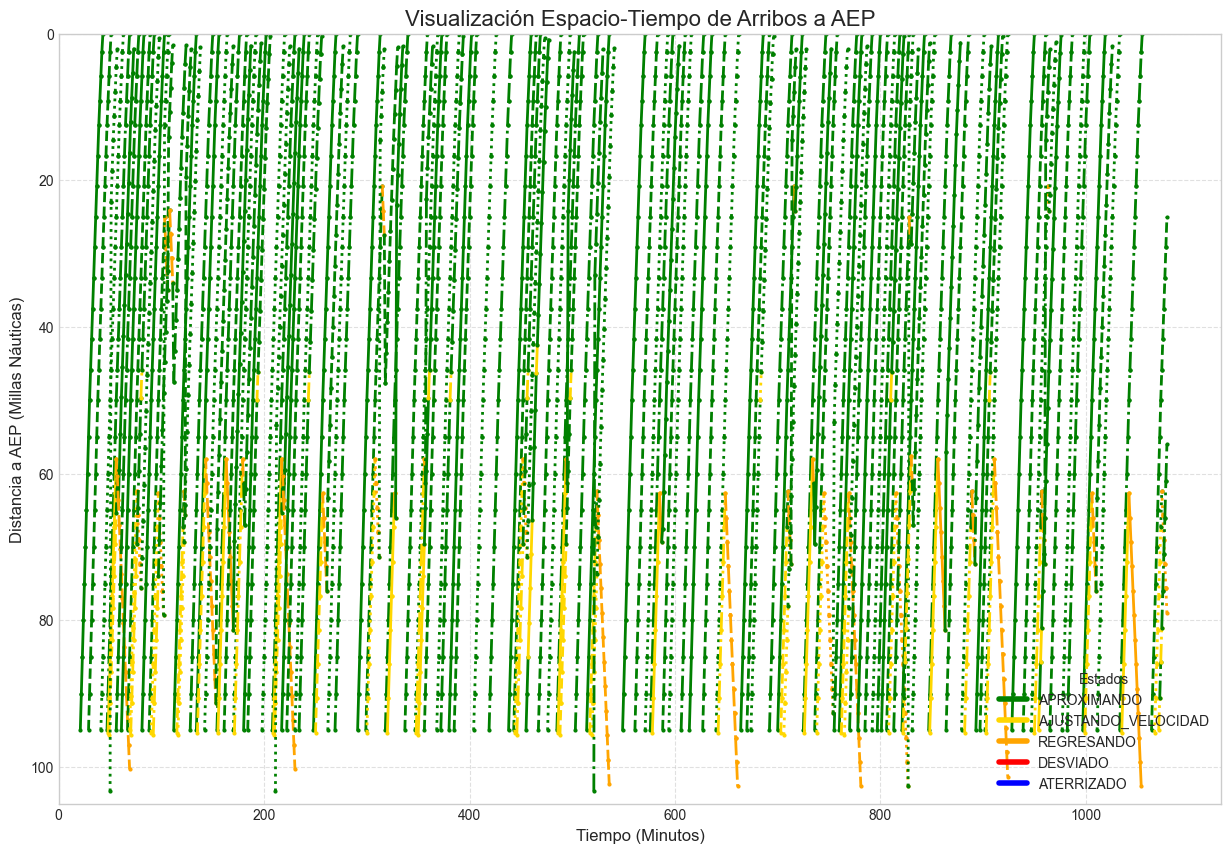

In [13]:
if __name__ == "__main__":
    # 1. Correr la simulación para obtener los datos
    historial = simular()
    # 2. Pasar los datos a la función de visualización
    visualizar_simulacion(historial)